In [2]:
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [3]:
from fastbook import *
from fastai.vision.widgets import *

In [4]:
# Importation clefs Microsoft Azure (Bing Image Search)
key = os.environ.get('AZURE_SEARCH_KEY', '3162016eb4634f779943ead7514ddc79')
torch.set_num_threads(1)

In [5]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

In [6]:
results = search_images_bing(key, 'truite fario')
ims = results.attrgot('contentUrl')
len(ims)

150

In [7]:
# test
ims = ['http://www.achigan.net/images/uploads/1336466785.jpg']

In [8]:
dest = 'images/fario.jpg'
download_url(ims[0], dest)

Path('images/fario.jpg')

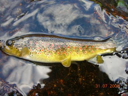

In [9]:
im = Image.open(dest)
im.to_thumb(128,128)

It worked !

Let's do the coding now

In [10]:
truite_types = 'fario', 'arc-en-ciel', 'de mer', 'lacustre'
path = Path('truite')

In [11]:
if not path.exists():
    path.mkdir()
    for o in truite_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} truite')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [12]:
fns = get_image_files(path)
fns

(#567) [Path('truite/fario/00000010.jpg'),Path('truite/fario/00000004.jpg'),Path('truite/fario/00000005.jpg'),Path('truite/fario/00000011.jpg'),Path('truite/fario/00000039.jpg'),Path('truite/fario/00000007.jpg'),Path('truite/fario/00000013.jpg'),Path('truite/fario/00000012.jpg'),Path('truite/fario/00000006.jpg'),Path('truite/fario/00000002.jpg')...]

In [13]:
failed = verify_images(fns)
failed

(#0) []

In [14]:
failed.map(Path.unlink);

Data Loader / training

In [15]:
# Creation of the dataLoaders maybe no need
class DataLoaders(GetAttr):
    def __init__(self, *loaders): self.loaders = loaders
    def __getitem__(self, i): return self.loaders[i]
    train,valid = add_props(lambda i,self: self[i])

In [16]:
truite = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [17]:
dls = truite.dataloaders(path, num_workers=0, device=torch.device('cpu'))

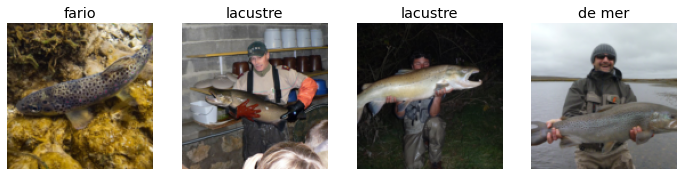

In [18]:
dls.valid.show_batch(max_n=4, nrows=1)

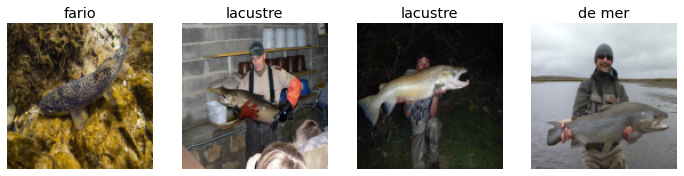

In [19]:
# Squish method (resize)
truite = truite.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = truite.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

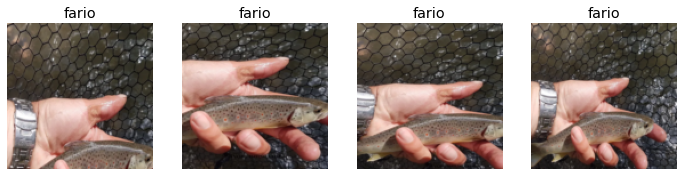

In [20]:
# Random method
truite = truite.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = truite.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

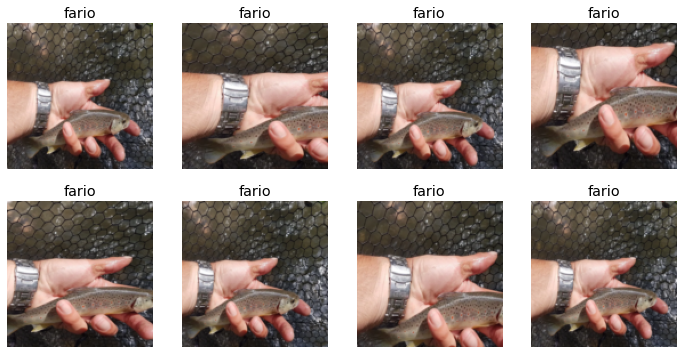

In [21]:
# Data Augmentation method
truite = truite.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dms = truite.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [22]:
'''for o in truite_types:
    # convert all PNG, GIF images to RGBA
    for image in os.listdir(path/o):
        ext = os.path.splitext(image)[1]
        
        if ext in ['.png', '.gif']:
            new_filename = os.path.splitext(image)[0]+'.png'
            img = Image.open(path/o/image)
            img.convert('RGBA')
            img.save(new_filename)
            print('saving: ' + new_filename)'''

"for o in truite_types:\n    # convert all PNG, GIF images to RGBA\n    for image in os.listdir(path/o):\n        ext = os.path.splitext(image)[1]\n        \n        if ext in ['.png', '.gif']:\n            new_filename = os.path.splitext(image)[0]+'.png'\n            img = Image.open(path/o/image)\n            img.convert('RGBA')\n            img.save(new_filename)\n            print('saving: ' + new_filename)"

Training the model

In [23]:
truite = truite.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = truite.dataloaders(path)

In [24]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.370018,1.976176,0.619469,01:42


/Users/teilo/opt/anaconda3/lib/python3.8/site-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/teilo/opt/anaconda3/lib/python3.8/site-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/teilo/opt/anaconda3/lib/python3.8/site-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,1.769253,1.300443,0.522124,03:32
1,1.595315,1.087884,0.415929,02:31
2,1.422190,1.056759,0.433628,02:22
3,1.314028,1.050756,0.415929,02:24


/Users/teilo/opt/anaconda3/lib/python3.8/site-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/teilo/opt/anaconda3/lib/python3.8/site-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/teilo/opt/anaconda3/lib/python3.8/site-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/teilo/opt/anaconda3/lib/python3.8/site-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/teilo/opt/anaconda3/lib/python3.8/site-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/teilo/opt/anaconda3/lib/python3.8/site-pack

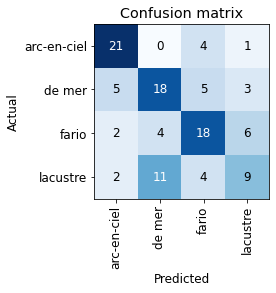

In [25]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [26]:
cleaner = ImageClassifierCleaner(learn)
cleaner

/Users/teilo/opt/anaconda3/lib/python3.8/site-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/teilo/opt/anaconda3/lib/python3.8/site-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [27]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

Exportation vers le site

In [28]:
learn.export()

In [29]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [30]:
learn_inf = load_learner(path/'export.pkl')

In [31]:
learn_inf.predict('images/fario.jpg')

('fario', TensorBase(2), TensorBase([0.0016, 0.0045, 0.5950, 0.3990]))

In [32]:
learn_inf.dls.vocab

['arc-en-ciel', 'de mer', 'fario', 'lacustre']

In [37]:
path = Path()
learn_inf = load_learner(path/'export.pkl', cpu=True)
btn_upload = widgets.FileUpload()
out_pl = widgets.Output()
lbl_pred = widgets.Label()

In [38]:
def on_data_change(change):
    lbl_pred.value = ''
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

In [39]:
btn_upload.observe(on_data_change, names=['data'])

In [42]:
display(VBox([widgets.Label('Montre ta Truite!'), btn_upload, out_pl, lbl_pred]))